
#### _ML продвинутые методы / ДЗ №1 / Практическая часть / Задача 3_

## 3. _Boosting vs Bagging_ 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [3]:
from sklearn.datasets import load_diabetes

data = load_diabetes()

X = data.data
y = data.target

X.shape, y.shape

((442, 10), (442,))

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=223)

print(X_train.shape, X_test.shape)

(353, 10) (89, 10)


### 3.1 _DecisionTreeRegressor_ 

In [5]:
%%time

dtr = DecisionTreeRegressor()

dtr_grid_params = {
    'max_depth' : list(range(2, 10)),
    'max_features' : [0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1.0],
    'min_samples_leaf' : list(range(1, 15))
}

gs_dtr = GridSearchCV(dtr, dtr_grid_params, scoring='neg_mean_squared_error', cv=4, iid=True, n_jobs=-1)
gs_dtr.fit(X_train, y_train)

best_dtr = gs_dtr.best_estimator_

Wall time: 7.76 s


In [6]:
best_dtr

DecisionTreeRegressor(criterion='mse', max_depth=8, max_features=0.5,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=12,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [7]:
-gs_dtr.best_score_

3633.395640099039

In [8]:
def print_scores(regr_name, dataset_name, y_test, y_pred):
    print('[{}] R2 ({}): {:.3f}'.format(regr_name, dataset_name, r2_score(y_test, y_pred)))
    print('[{}] MSE ({}): {:.3f}'.format(regr_name, dataset_name, mean_squared_error(y_test, y_pred)))
    print()
    print('*' * 50)

In [9]:
y_dtr_pred = best_dtr.predict(X_test)

In [10]:
print_scores('DecisionTreeRegressor', 'train', y_train, best_dtr.predict(X_train))
print_scores('DecisionTreeRegressor', 'test', y_test, y_dtr_pred)

[DecisionTreeRegressor] R2 (train): 0.578
[DecisionTreeRegressor] MSE (train): 2476.864

**************************************************
[DecisionTreeRegressor] R2 (test): 0.308
[DecisionTreeRegressor] MSE (test): 4257.891

**************************************************


### 3.2 _RandomForestRegressor_

Параметры для решающего дерева возьмём равными найденным выше для `DecisionTreeRegressor`.

In [11]:
%%time

rfr_params = {k:v for (k,v) in best_dtr.get_params().items() 
                  if k in ['max_depth', 'max_features', 'min_samples_leaf', 'min_samples_split']}

rfr = RandomForestRegressor(n_estimators=50, **rfr_params)

print( -cross_val_score(rfr, X_train, y_train, cv=4, scoring='neg_mean_squared_error').mean() )

3229.0576194558325
Wall time: 360 ms


In [12]:
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=12, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [13]:
y_rfr_pred = rfr.predict(X_test) 

In [14]:
print_scores('RandomForestRegressor', 'train', y_train, rfr.predict(X_train))
print_scores('RandomForestRegressor', 'test', y_test, y_rfr_pred)

[RandomForestRegressor] R2 (train): 0.604
[RandomForestRegressor] MSE (train): 2325.952

**************************************************
[RandomForestRegressor] R2 (test): 0.465
[RandomForestRegressor] MSE (test): 3292.178

**************************************************


#### 3.2.1 _Number of trees in RandomForest_

In [15]:
from tqdm import tqdm

In [16]:
n_trees = np.arange(5,300,25)
scores = []

rfr_params = {k:v for (k,v) in rfr.get_params().items() 
                        if k in ['max_depth', 'max_features', 'min_samples_leaf', 
                                 'min_samples_split', 'min_weight_fraction_leaf']}

for n in tqdm(n_trees):
    rfr = RandomForestRegressor(n_estimators=n, n_jobs=-1, **rfr_params)
    scores.append(-cross_val_score(rfr, X, y, cv=4, scoring='neg_mean_squared_error').mean())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:21<00:00,  2.35s/it]


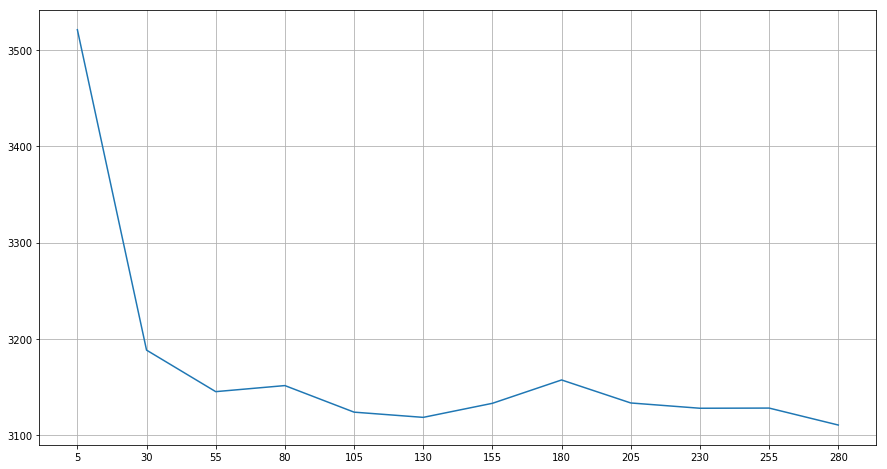

In [17]:
plt.figure(figsize = (15, 8))
plt.plot(scores)
plt.xticks(np.arange(len(n_trees)), n_trees);
plt.grid()

### 3.3 _GradientBoostingRegressor_